# Financial Time Series Data

## Entropy Application in the Stock Market

**Monitoring Correlation-Based Networks over time with Structural Entropy**

A lot of definitions and formulations of entropy are available. What in general is true is that entropy is used to measure information, surprise or uncertainty regarding experiments possible outcomes. In particular Shannon entropy is the one that is used most frequently in statistics and machine learning. For this reason, it's the focus of our attention here. 

Surprise and uncertainty are daily concepts in the financial market. So using the entropy as an instrument to explore the market sounds like a very spicy idea. What we expect is to reveal a remarkable pattern between the new meassure and the volatility of the asset's prices over time. 

It's valuable to introduce the standard approach and considerations provided in this [work]([work](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6658667/)). The authors introduced the concept of Structural Entropy and used it to monitor a correlation based network over time with applications to financial markets.

### The data 

For the analysis we use daily closing prices from a dataset collected on Kaggle. It stores 32 stocks, from different market sectors, that were traded continuosly from 2000 to 2018. For each stock in the dataset, we derive a time series of its daily log-returns. Log differencing the price (log-returns) can generate stationary and normally distributed signals suitable for our scope  

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

import networkx as nx
from sklearn.decomposition import PCA
from scipy.sparse.csgraph import connected_components

In [2]:
### READ DATA ###

df = pd.read_csv('financial_data_2000_2018_cleaned.csv.zip', index_col=0)
df['timestamp'] = df.timestamp.apply(datetime.fromtimestamp)
df.sort_values(['stock','timestamp'], inplace=True)

print(df.shape)
df.head()

(168615, 7)


,stock,timestamp,open,high,low,adj_close,volume
13589,AAPL,2000-07-30 17:00:00,3.11,3.27,3.27,3.22,38824800
13588,AAPL,2000-07-31 17:00:00,3.18,3.24,3.24,3.12,34321000
13587,AAPL,2000-08-01 17:00:00,3.10,3.16,3.16,2.99,40588800
13586,AAPL,2000-08-02 17:00:00,2.88,3.04,3.04,3.04,84974400
13585,AAPL,2000-08-03 17:00:00,3.13,3.24,3.24,3.00,65780400


In [3]:
### MANAGE CLOSE PRICES (STOCKS, TIMESTEMPS) ###

df_close = df.set_index(['stock','timestamp'])['adj_close'].unstack()
df_close = df_close.loc[~df_close.isna().any(axis=1)].copy()

df_close.head()

timestamp,2000-07-30 17:00:00,2000-07-31 17:00:00,2000-08-01 17:00:00,2000-08-02 17:00:00,2000-08-03 17:00:00,2000-08-06 17:00:00,2000-08-07 17:00:00,2000-08-08 17:00:00,2000-08-09 17:00:00,2000-08-10 17:00:00,...,2018-07-17 17:00:00,2018-07-18 17:00:00,2018-07-19 17:00:00,2018-07-22 17:00:00,2018-07-23 17:00:00,2018-07-24 17:00:00,2018-07-25 17:00:00,2018-07-26 17:00:00,2018-07-29 17:00:00,2018-07-30 17:00:00
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,3.22,3.12,2.99,3.04,3.00,3.03,2.96,3.01,3.01,3.02,...,189.73,191.21,190.77,190.94,192.33,194.14,193.53,190.31,189.25,189.63
ADBE,28.44,28.43,28.89,28.26,29.00,30.32,30.17,28.89,28.02,28.71,...,259.78,257.68,257.54,259.47,257.49,263.17,261.93,254.81,242.32,244.68
ADSK,5.24,5.02,5.20,5.53,5.52,5.61,5.74,5.70,5.79,5.82,...,137.43,134.50,134.32,134.50,132.31,135.85,136.14,131.16,127.00,128.44
AMAT,29.79,29.27,28.48,27.08,26.59,27.45,27.70,28.31,27.18,27.16,...,48.06,46.46,46.55,46.22,45.70,45.75,46.95,48.08,47.69,48.41
AMZN,30.13,30.25,30.81,31.50,32.50,33.81,32.94,30.88,30.44,33.69,...,1842.92,1812.97,1813.70,1802.00,1829.24,1863.61,1808.00,1817.27,1779.22,1777.44


In [4]:
### MANAGE LOG RETURNS (STOCKS, TIMESTEMPS) ###

df_logret = (df_close.pct_change(axis=1)).apply(np.log1p)

df_logret.head()

timestamp,2000-07-30 17:00:00,2000-07-31 17:00:00,2000-08-01 17:00:00,2000-08-02 17:00:00,2000-08-03 17:00:00,2000-08-06 17:00:00,2000-08-07 17:00:00,2000-08-08 17:00:00,2000-08-09 17:00:00,2000-08-10 17:00:00,...,2018-07-17 17:00:00,2018-07-18 17:00:00,2018-07-19 17:00:00,2018-07-22 17:00:00,2018-07-23 17:00:00,2018-07-24 17:00:00,2018-07-25 17:00:00,2018-07-26 17:00:00,2018-07-29 17:00:00,2018-07-30 17:00:00
stock,,,,,,,,,,,,,,,,,,,,,
AAPL,NaN,-0.031548,-0.042560,0.016584,-0.013245,0.009950,-0.023373,0.016751,0.000000,0.003317,...,-0.005519,0.007770,-0.002304,0.000891,0.007253,0.009367,-0.003147,-0.016778,-0.005585,0.002006
ADBE,NaN,-0.000352,0.016051,-0.022048,0.025848,0.044512,-0.004960,-0.043353,-0.030577,0.024327,...,0.005675,-0.008117,-0.000543,0.007466,-0.007660,0.021819,-0.004723,-0.027559,-0.050259,0.009692
ADSK,NaN,-0.042892,0.035229,0.061529,-0.001810,0.016173,0.022908,-0.006993,0.015666,0.005168,...,0.006351,-0.021550,-0.001339,0.001339,-0.016417,0.026404,0.002132,-0.037266,-0.032231,0.011275
AMAT,NaN,-0.017610,-0.027361,-0.050407,-0.018260,0.031831,0.009066,0.021783,-0.040734,-0.000736,...,0.020602,-0.033859,0.001935,-0.007114,-0.011314,0.001093,0.025891,0.023783,-0.008145,0.014985
AMZN,NaN,0.003975,0.018343,0.022148,0.031253,0.039517,-0.026069,-0.064579,-0.014351,0.101444,...,-0.000548,-0.016385,0.000403,-0.006472,0.015003,0.018615,-0.030294,0.005114,-0.021160,-0.001001


In [5]:
### DEFINE WINDOW LENGTH AS HYPERPARAMETER ###

sequence_length = 200

<AxesSubplot: title={'center': 'logret distributions'}, ylabel='Frequency'>

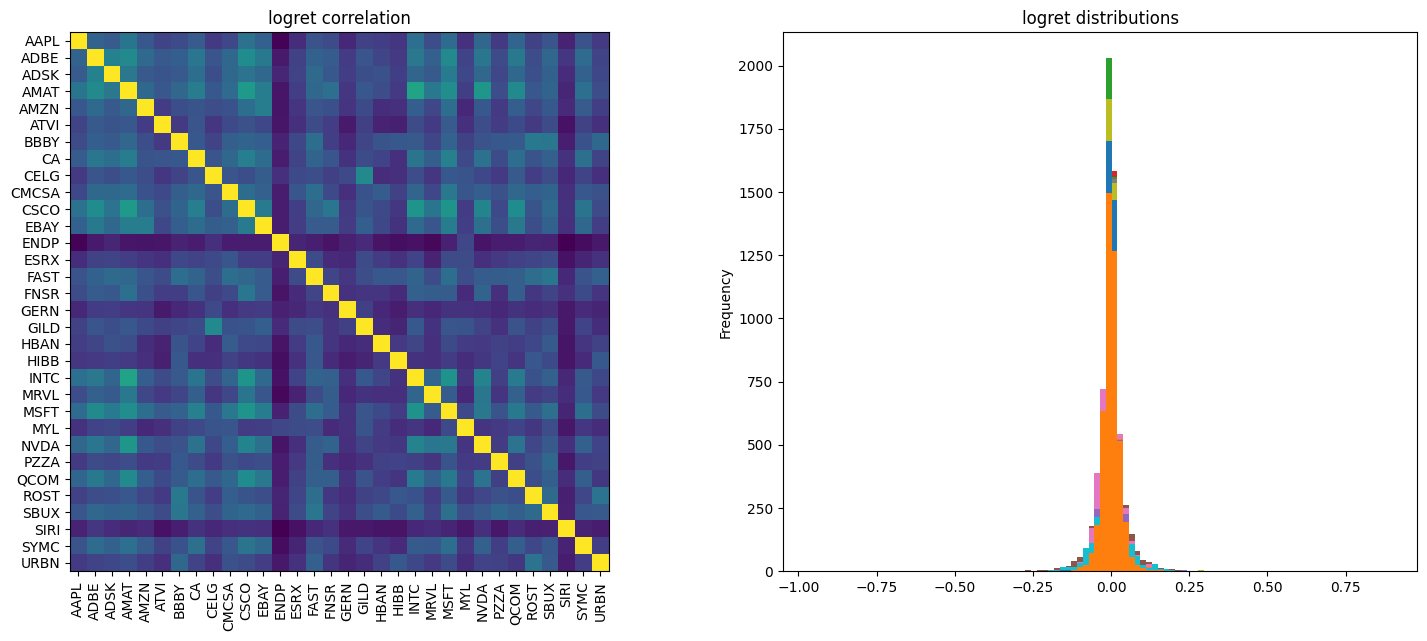

In [6]:
### PLOT RAW LOG RETURN STATISTICS ###

plt.figure(figsize=(18,7))

plt.subplot(121)
plt.imshow(df_logret.T.corr())
plt.xticks(range(df_logret.shape[0]), df_logret.index, rotation=90)
plt.yticks(range(df_logret.shape[0]), df_logret.index)
plt.title('logret correlation')

plt.subplot(122)
df_logret.T.plot.hist(bins=100, legend=False, ax=plt.gca(), title='logret distributions')

We start exploring the presence of turbulence in the data with conventional measurements. Volatility is a statistical measure of the dispersion of returns for a given market index. This measure refers to the level of uncertainty or risk associated with the size of changes in the market. A high volatility level corresponds to a high range of fluctuations in the prices of the stocks. This means that the price of an asset can change dramatically over a short period in either direction. A lower volatility means that the asset value does not fluctuate dramatically, and tends to be more steady.

<AxesSubplot: title={'center': 'logret sliding std'}, xlabel='timestamp'>

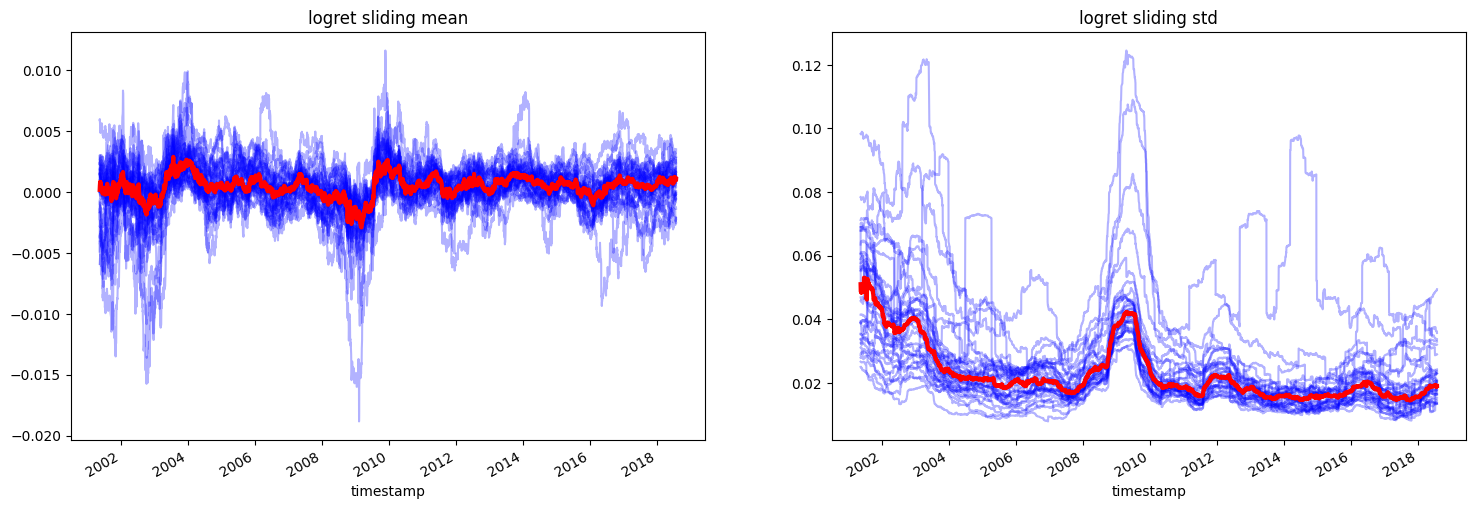

In [7]:
### PLOT LOG RETURN SLIDING STATISTICS ###

plt.figure(figsize=(18,6))

plt.subplot(121)
df_logret.T.rolling(sequence_length).mean().plot(legend=False, color='blue', alpha=0.3, ax=plt.gca(), 
                                                 title='logret sliding mean')
df_logret.T.rolling(sequence_length).mean().median(axis=1).plot(color='red', linewidth=3, ax=plt.gca())

plt.subplot(122)
df_logret.T.rolling(sequence_length).std().plot(legend=False, color='blue', alpha=0.3, ax=plt.gca(), 
                                                title='logret sliding std')
df_logret.T.rolling(sequence_length).std().median(axis=1).plot(color='red', linewidth=3, ax=plt.gca())

### Structural Entropy

One particularly interesting idea is the representation of financial markets as correlation-based networks. In the case of financial markets, network nodes are financial assets and network edges are interactions between them, where such an interaction is typically measured by the magnitude of price correlations over time. The representation of financial markets as networks is valuable to identify turbulence or structural breaks.

To calculate the Structural Entropy in a given time range, we need to follow a defined workflow:

- Measure the Pearson correlation of the series, resulting in an NxN symmetric matrix.
- Create an adjacency matrix as the representation of the network edges. A standard approach is to use a threshold to determine which values of the correlation matrix will be transformed into edges in the network.
- On the adjacency matrix, we apply a community detection algorithm (connected components in our case).
- The resulting labels (vector of integers) of the clustering procedure are used to calculate the classical Shannon entropy. More specifically, we compute the entropy on the cluster count frequencies. The resulting value is defined as the Structural Entropy of a network.

Putting these steps together in a sliding window procedure, we can monitor the dynamics over time in the system of our interest. The result is a new single time series of Structural Entropy values.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*cYfEbAfrRCAjFbuAqvtnNg.png)

In [8]:
### DEFINE UTILITY FUNCTIONS FOR STRUCTURAL ENTROPY CALCULATION ###

def get_timespan(df, start, end):
                                    
    return df.iloc[:,start:end].T

def corr_matrix(df, start, end):
    
    seq = get_timespan(df, start, end)
    corr_seq = seq.corr().values
    
    return corr_seq

def structural_entropy(df_logret, sequence_length, t):
    
    structural_entropy = {'timestamp':[], 'structural_entropy':[]}

    for d in tqdm(range(sequence_length, df_logret.shape[1])):

        _corr = corr_matrix(df_logret, d-sequence_length, d)

        _corr = (np.abs(_corr)>t).astype(int)
        _, _labels = connected_components(_corr)

        _, _count = np.unique(_labels, return_counts=True)
        _countnorm = _count / _count.sum()
        _entropy = -(_countnorm*np.log2(_countnorm)).sum()

        structural_entropy['timestamp'].append(df_logret.columns[d])
        structural_entropy['structural_entropy'].append(_entropy)

    structural_entropy = pd.Series(structural_entropy['structural_entropy'], 
                                   index=structural_entropy['timestamp'])
    
    return structural_entropy

In [9]:
### CALCULATE STRUCTURAL ENTROPY WITH VARIOUS THRESHOLDS TO CREATE ADJACENT MATRIXES ###

structural_entropy_05 = structural_entropy(df_logret, sequence_length, 0.5)
structural_entropy_06 = structural_entropy(df_logret, sequence_length, 0.6)
structural_entropy_07 = structural_entropy(df_logret, sequence_length, 0.7)
structural_entropy_08 = structural_entropy(df_logret, sequence_length, 0.8)

100%|██████████| 4330/4330 [00:15<00:00, 273.10it/s]


Generally speaking, Structural Entropy can be interpreted as an adjusted version of the well known Shannon index. Both of them are indexes of diversity but the Structural Entropy can extract value from a complex structure with spatial and temporal dependencies.

The adoption of the whole procedure, on the series at our disposal, produces the results depicted below.

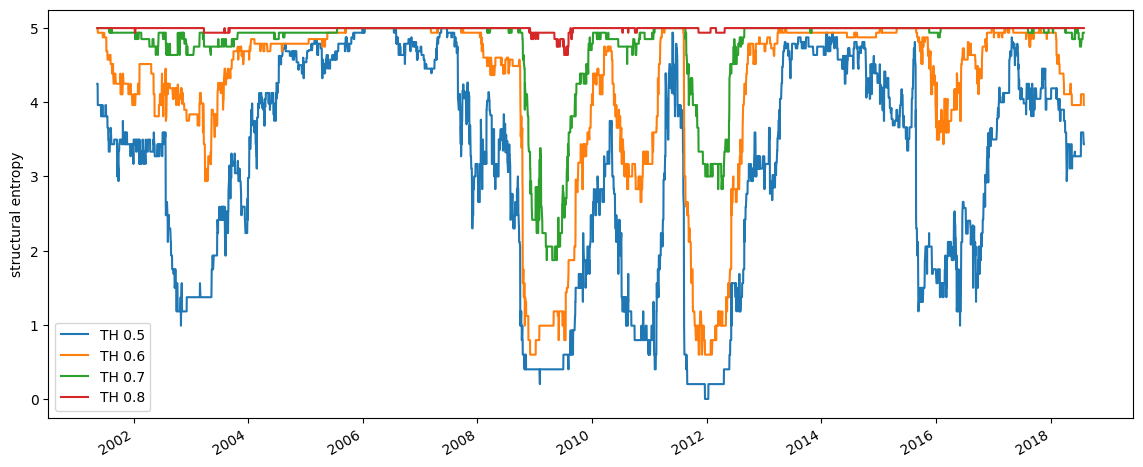

In [10]:
### PLOT STRUCTURAL ENTROPY WITH VARIOUS THRESHOLDS TO CREATE ADJACENT MATRIXES ###

plt.figure(figsize=(14,6))

structural_entropy_05.plot(label='TH 0.5')
structural_entropy_06.plot(label='TH 0.6')
structural_entropy_07.plot(label='TH 0.7')
structural_entropy_08.plot(label='TH 0.8')

plt.ylabel('structural entropy'); plt.legend()

The minimal reachable value for the Structural Entropy is 0, and this is obtained when all nodes in the network are assigned to the same community (i.e., a single huge community). The maximum is reached when each node constitutes a single community. The maximal depends on the number of nodes in the network (the number of series observed).

As we can see, in our case the Structural Entropy can capture the turbulences present in the early years of the new millennium (dot-com bubble), after 2008 (recent financial crisis), and in some subsequent periods. A visual explanation of what happens under the hood is available if we think about the correlation matrix as a graph and plot it with scatters. The dots represent each single stocks (our network nodes), the colors are the clusters to which the stocks belong to (created by the community detection algorithm), and the edges are the strongness of the relations, which are drawn if the correlation of two stocks exceeds a certain amount.

In [11]:
### EXPLORE EDGE CASES IN STRUCTURAL ENTROPY CALCULATION ###

reference_entropy = structural_entropy_06.copy()

id_max = np.random.choice(
    np.where(reference_entropy == reference_entropy.max())[0]
) + sequence_length

id_mean = np.random.choice(
    np.where(reference_entropy.round(1) == round((reference_entropy.max() + 
                                                  reference_entropy.min())/2, 1))[0]
) + sequence_length

id_min = np.random.choice(
    np.where(reference_entropy == reference_entropy.min())[0]
) + sequence_length


df_logret.columns[id_min], df_logret.columns[id_mean], df_logret.columns[id_max]

(Timestamp('2011-12-20 18:00:00'),
 Timestamp('2010-11-14 18:00:00'),
 Timestamp('2006-01-25 18:00:00'))

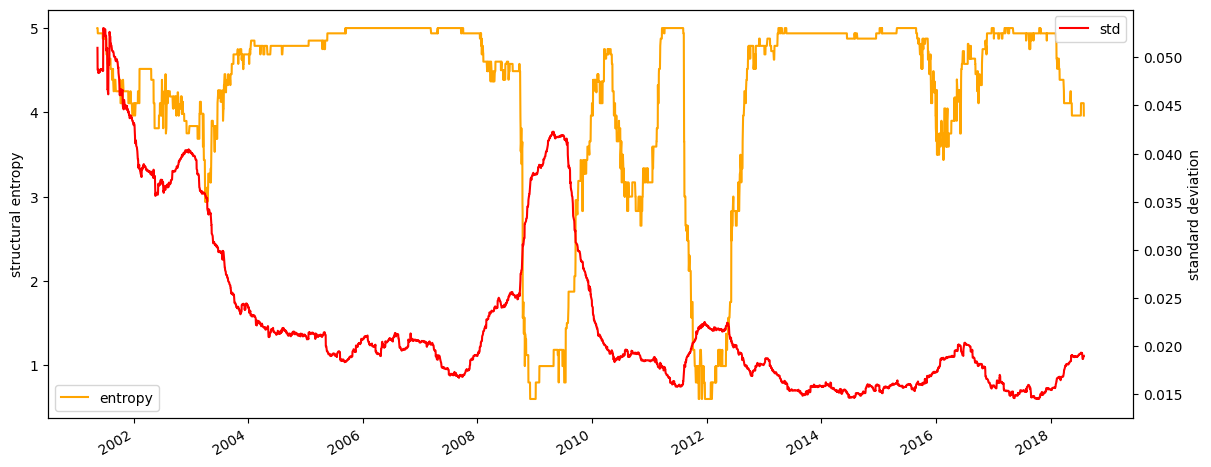

In [12]:
### COMPARE STRUCTURAL ENTROPY AND VOLATILITY ###

plt.figure(figsize=(14,6))

reference_entropy.plot(label='entropy', color='orange')
plt.ylabel('structural entropy')
plt.legend()

plt.twinx()
df_logret.T.rolling(sequence_length).std().median(axis=1).plot(label='std', color='red')
plt.ylabel('standard deviation')

plt.legend()

In [13]:
### UTILITY FUNCTION TO PLOT CORRELATION MATRIX NETWORK ###

def create_graph_corr(df_logret, id_, sequence_length, 
                      thresh_cluster, thresh_edge):
    
    _corr = corr_matrix(df_logret, id_-sequence_length, id_)
    _pca = PCA(n_components=2, random_state=33).fit_transform(_corr)
    
    clusters = (np.abs(_corr)>=thresh_cluster).astype(int)
    _, _labels = connected_components(clusters)
    
    results = dict()
    
    results['edges'] = [(x,y) for x,y in zip(*np.where(np.abs(_corr)>=thresh_edge))]
    results['pos'] = {i:(_pca[i,0], _pca[i,1]) for i in range(len(_labels))}
    results['node_color'] = _labels
    results['nodelist'] = range(len(_labels))
    
    return results

As we can see, in our case the Structural Entropy can capture the turbulences present in the early years of the new millennium (dot-com bubble), after 2008 (recent financial crisis), and in some subsequent periods. A visual explanation of what happens under the hood is available if we think about the correlation matrix as a graph and plot it with scatters. The dots represent each single stocks (our network nodes), the colors are the clusters to which the stocks belong to (created by the community detection algorithm), and the edges are the strongness of the relations, which are drawn if the correlation of two stocks exceeds a certain amount.

Text(0.5, 1.0, 'max structural entropy')

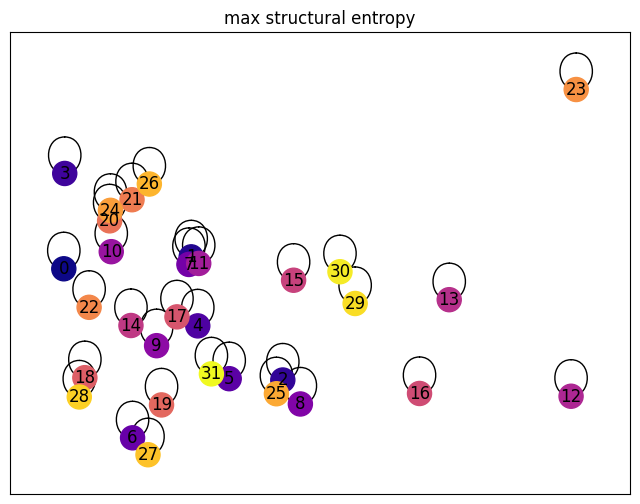

In [14]:
### PLOT A NETWORK WITH MAX STRUCTURAL ENTROPY ###

graph_param = create_graph_corr(df_logret, id_max, sequence_length, 
                                thresh_cluster=0.6, thresh_edge=0.7)
G = nx.Graph()
G.add_edges_from(graph_param['edges'])
del graph_param['edges']

plt.figure(figsize=(8,6))
nx.draw_networkx(G, **graph_param, cmap='plasma')
plt.title('max structural entropy')

Text(0.5, 1.0, 'medium structural entropy')

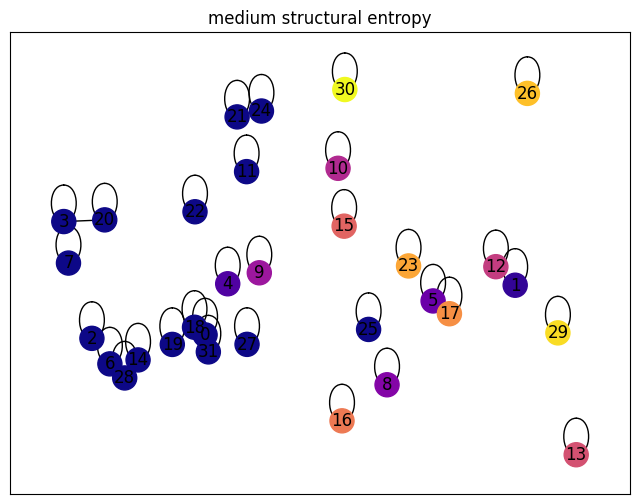

In [15]:
### PLOT A NETWORK WITH MEDIUM STRUCTURAL ENTROPY ###

graph_param = create_graph_corr(df_logret, id_mean, sequence_length, 
                                thresh_cluster=0.6, thresh_edge=0.7)
G = nx.Graph()
G.add_edges_from(graph_param['edges'])
del graph_param['edges']

plt.figure(figsize=(8,6))
nx.draw_networkx(G, **graph_param, cmap='plasma')
plt.title('medium structural entropy')

Text(0.5, 1.0, 'min structural entropy')

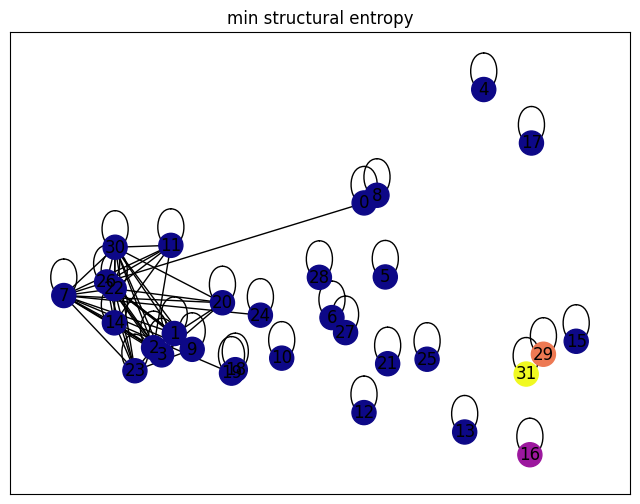

In [16]:
### PLOT A NETWORK WITH MIN STRUCTURAL ENTROPY ###

graph_param = create_graph_corr(df_logret, id_min, sequence_length, 
                             thresh_cluster=0.6, thresh_edge=0.7)
G = nx.Graph()
G.add_edges_from(graph_param['edges'])
del graph_param['edges']

plt.figure(figsize=(8,6))
nx.draw_networkx(G, **graph_param, cmap='plasma')
plt.title('min structural entropy')

In the periods of maximum Structural Entropy, the stocks tend to stay on their own, forming unique clusters. In the period of medium entropy, we can see that some stocks belong to the same cluster and are related by some strong correlations. In the period of low Structural Entropy, most of the stocks belong to the same community and are linked by a lot of correlation relationships.

### Summary

In this post, we presented an alternative method to look at the changes in the geometric structure of the price series. The price of an asset varies in function of the available information. A simple change in the information will be immediately priced in. The connected nature of financial markets needs the adoption of a measure to catch the spatial and temporal dimensions. In this sense, Structural Entropy helps us to make statements and perform computations in this scenario about situations involving uncertainties.